In [24]:
import jax
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
from typing import Sequence
from functools import partial
from tqdm import tqdm
import optax

In [67]:
class lorenz1996_odeint():
    def __init__(self, N: int, F:int, time_range, initial_state, time_constant=10, rescale_factor=1) -> None:
        self.N = N
        self.F = F
        self.time_range = time_range # (start, end, spacing)
        self.initial_state = initial_state
        self.time_constant = time_constant
        self.rescale_factor = rescale_factor
        self.sol = None
    
    def dfdt(self, state, t):
        x_l1 = np.roll(state, -1)
        x_r2 = np.roll(state, 2)
        x_r1 = np.roll(state, 1)
        return ((x_l1-x_r2)*x_r1 - state + self.F)/self.time_constant

    def generate_sol(self):
        self.sol = self.rescale_factor*odeint(self.dfdt, self.initial_state, np.arange(*self.time_range))

class HH_Neuron():
    def __init__(self) -> None:
        self.C = 1.0 # neuron capacitance
        self.gn = 120.0 # maximum Na conductance
        self.vna = 50.0 # Na reversal potential
        self.gk = 20.0 # maximum K conductance
        self.vk = -77.0 # K reversal potential
        self.gl = 0.3  # maximum leak condunctance
        self.vl = -54.4 # leak reversal potential

        # parameters used in the dynamics of the subunits of the ion channels
        self.vm, self.dvm = -40.0, 15.0
        self.tm0, self.tm1 = 0.1, 0.4
        self.vn, self.dvn = -55.0, 30.0
        self.tn0, self.tn1 = 1.0, 5.0
        self.vh, self.dvh  = -60.0, -15.0
        self.th0, self.th1 = 1.0, 7.0

        # parameters used in the dynamics of synapses
        self.v0, self.dv0 = -5.0, 5.0
        self.S1, self.S2 = 3.0/2.0, 5.0/3.0
        self.tau1, self.tau2 = 1.0, 3.0
        self.Ereve, self.Erevi = 0.0, -80.0

    def HH_intrinsic(self, V, m, h, n):
        """Output is the contribution to the current (positive direction is from outside to inside of the neuron) from the intrinsic dynamics of Hodgkin-Huxley neuron"""
        i_Na = self.gn*(m**3)*h*(self.vna - V)
        i_K = self.gk*(n**4)*(self.vk - V)
        i_L = self.gl*(self.vl - V)
        return i_Na + i_K + i_L

    def _g_fun(self, V, A, B):
        """Used in the dynamics of subunits of ion channels"""
        return 0.5*(1+np.tanh((V-A)/B))

    def _tau_fun(self, V, t0, t1, A, B):
        """Used in the dynamics of subunits of ion channels"""
        return t0+t1*(1.0 - np.tanh((V-A)/B)**2)

    def _S0(self, V):
        """Used in the dynamics of synapses"""
        return self._g_fun(V, self.v0, self.dv0)

    def dmdt(self, V, m):
        """dm/dt"""
        return (self._g_fun(V, self.vm, self.dvm) - m)/self._tau_fun(V, self.tm0, self.tm1, self.vm, self.dvm)

    def dndt(self, V, n):
        """dn/dt"""
        return (self._g_fun(V, self.vn, self.dvn) - n)/self._tau_fun(V, self.tn0, self.tn1, self.vn, self.dvn)
    
    def dhdt(self, V, h):
        """dh/dt"""
        return (self._g_fun(V, self.vh, self.dvh) - h)/self._tau_fun(V, self.th0, self.th1, self.vh, self.dvh)

    def dSedt(self, V_pre, Se):
        """dSe/dt"""
        s0 = self._S0(V_pre)
        return (s0 - Se)/self.tau1/(self.S1 - s0)

    def dSidt(self, V_pre, Si):
        """dSi/dt"""
        s0 = self._S0(V_pre)
        return (s0 - Si)/self.tau2/(self.S2 - s0)

class single_neuron_odeint():
    def __init__(self, stimulus, neuron_initial_state, dc_stimulus=0) -> None:
        self.neuron = HH_Neuron()
        self.stimulus = stimulus
        self.time_range = self.stimulus.time_range
        self.dc_stimulus = dc_stimulus
        self.neuron_initial_state = neuron_initial_state
        self.sol = None

    def dfdt(self, state, t):
        V, m, h, n = tuple(state)
        t_start, t_end, t_spacing = self.time_range
        t_idx = int(round((t-t_start)/t_spacing))
        t_idx = min(t_idx, int(round((t_end-t_start)/t_spacing))-1)
        dVdt = (self.neuron.HH_intrinsic(V, m, h, n) + self.dc_stimulus + self.stimulus.sol[t_idx, 0])/self.neuron.C
        dmdt = self.neuron.dmdt(V, m)
        dhdt = self.neuron.dhdt(V, h)
        dndt = self.neuron.dndt(V, n)
        return [dVdt, dmdt, dhdt, dndt]

    def generate_sol(self):
        self.sol = odeint(self.dfdt, self.neuron_initial_state, np.arange(*self.time_range))

class mlp(nn.Module):
    network_struct: Sequence[int]

    def setup(self) -> None:
        self.layers = [nn.Dense(i) for i in self.network_struct]

    def __call__(self, x):
        x = jnp.atleast_2d(x)
        for i in range(len(self.layers)-1):
            x = self.layers[i](x)
            # x = nn.relu(x)
            x = nn.softplus(x)
        x = self.layers[-1](x)
        return x

class prediction_model(nn.Module):
    ann: nn.Module
    time_spacing: float
    
    def setup(self) -> None:
        self.membrane_c_inverse = self.param("1/C", jax.nn.initializers.uniform(2), (1, ))
        self.membrane_leak = self.param("leak", jax.nn.initializers.uniform(2), (1, ))

    def __call__(self, x, avg_current):
        """x is the time_delay coordinate.
        current is the average current of the interval between present time and the time of prediction. (usually it is simply (I(t) + I(t+h)/2)"""
        V = x[..., -1] # the voltage at time t.
        temp = self.ann(x)
        temp = temp.reshape(temp.shape[:-1]) # change shape from (..., 1) to (...)
        # return V + (temp + self.membrane_c_inverse*avg_current - self.membrane_leak*V)*self.time_spacing
        return V + (temp + avg_current)*self.time_spacing
        
class train():
    def __init__(self, 
        stimulus_list: Sequence[float], # 1d array
        voltage_list: Sequence[float], # 1d array
        model: prediction_model,
        time_delay: int,
        time_delay_dim: int,
        time_range: Sequence[int], #(start, end, spacing)
        batch_size: int):

        self.stimulus_list = stimulus_list
        self.voltage_list = voltage_list
        self.model = model
        self.time_delay, self.time_delay_dim = time_delay, time_delay_dim
        self.time_range = time_range
        self.batch_size = batch_size
        self.n_batches = None
        self.batches = None 
        # the shape of batches is (n_batches, batch_size, time_delay_dim + 2)
        # the last dimension of batches is (V(t-n*tau), V(t-(n-1)*tau), ..., V(t-tau), V(t))
        self.loss_list = None

    def get_batches(self, key):
        t_start, t_end, t_spacing = self.time_range
        first_usable_t_idx = self.time_delay*(self.time_delay_dim-1) # the first point that can be used for training is the time_delay*(time_delay_dim-1)^th point.
        n_points = int((t_end-t_start)/t_spacing) - first_usable_t_idx - 1 # -1 because the prediction always needs the data at the next time step
        tmp_v = jnp.array([jnp.roll(self.voltage_list, -i*self.time_delay) for i in range(self.time_delay_dim)]).T
        tmp_v = tmp_v[:-first_usable_t_idx-1, :]
        tmp_pred_v = self.voltage_list[first_usable_t_idx+1:].reshape((-1, 1))
        tmp_i = (self.stimulus_list + jnp.roll(self.stimulus_list, -1))/2
        tmp_i = tmp_i[first_usable_t_idx:-1].reshape((-1, 1))
        tmp = jnp.concatenate((tmp_v, tmp_i, tmp_pred_v), axis=-1) # dim of tmp is (n_points, time_delay_dim+2)
        tmp = jax.random.permutation(key, tmp, axis=0, independent=False)
        self.n_batches = int(n_points/self.batch_size)
        self.batches = tmp[:self.n_batches*self.batch_size, :].reshape((self.n_batches, self.batch_size, -1))
        
    @partial(jax.jit, static_argnums=(0, ))
    def loss(self, params, batch):
        xs = batch[:, :-2]
        stimulus_current = batch[:, -2]
        preds_true = batch[:, -1]
        preds = self.model.apply(params, xs, stimulus_current)
        return jnp.sum((preds - preds_true)**2)/self.batch_size

    @partial(jax.jit, static_argnums=(0, ))
    def loss_and_grad(self, params, batch):
        return jax.value_and_grad(self.loss, argnums=0)(params, batch)

    def run(self, params, n_epochs, optimizer):
        pbar = tqdm(range(n_epochs))
        tx = optimizer
        # tx = optax.sgd(learning_rate=lr, momentum=0.9)
        opt_state = tx.init(params)
        self.loss_list = np.zeros(n_epochs)
        for i in pbar:
            batch_idx = i%self.n_batches
            # print(batch_idx)
            loss_val, grads = self.loss_and_grad(params, self.batches[batch_idx])
            updates, opt_state = tx.update(grads, opt_state)
            params = optax.apply_updates(params, updates)
            self.loss_list[i] = loss_val
            pbar.set_postfix({"loss": loss_val})
        return params

class generate_prediction():
    def __init__(self, model: prediction_model, time_delay:int, time_delay_dim: int, stimulus_list: Sequence[float], initial_piece: Sequence[float]) -> None:
        """the fist element of stimulus_list should be the stimulus current at t0.
        the initial_piece should be a sequence of voltages from (t0 - time_delay*(tine_delay_dim-1)) to t0. (the length of this sequence is time_delay*(time_delay_dim-1)+1)
        """
        self.model = model
        self.time_delay, self.time_delay_dim = time_delay, time_delay_dim
        self.avg_i = ((stimulus_list + jnp.roll(stimulus_list, -1))/2)[:-1]
        self.initial_piece = initial_piece
        self.prediction_list = np.concatenate((self.initial_piece, np.zeros(len(self.avg_i))))

    def run(self, params, n_steps=None):
        initial_piece_len = self.time_delay*(self.time_delay_dim-1)+1
        v_indices = np.array([n*self.time_delay for n in range(self.time_delay_dim)]) # -1 because of python indexing convention
        if n_steps is not None:
            n_steps = min(n_steps, len(self.avg_i))
        for i in tqdm(range(n_steps)):
            state = jnp.array(self.prediction_list[v_indices])
            next_v = self.model.apply(params, state, self.avg_i[i])
            self.prediction_list[i+initial_piece_len] = next_v
            v_indices = v_indices + 1

In [68]:
time_range = (0, 1000, 0.1)
time_delay = 10
time_delay_dim = 5 
stimulus = lorenz1996_odeint(N=8, F=6, time_range=time_range, initial_state=[1, 2, 8.01, 4, 8, 5], time_constant=10, rescale_factor=0.8)
stimulus.generate_sol()
stimulus.sol = np.ones(stimulus.sol.shape)*15
single_neuron = single_neuron_odeint(stimulus, [0, 0, 0, 0])
single_neuron.generate_sol()

In [35]:
time_range = (0, 500, 1)
time_delay = 10
time_delay_dim = 5 
stimulus = lorenz1996_odeint(N=8, F=6, time_range=time_range, initial_state=[1, 2, 8.01, 4, 8, 5], time_constant=10, rescale_factor=0.8)
stimulus.generate_sol()
stimulus.sol = np.ones(stimulus.sol.shape)*15
single_neuron = single_neuron_odeint(stimulus, [0, 0, 0, 0])
single_neuron.generate_sol()
network = mlp((500, 1))
pred_model = prediction_model(network, time_spacing=time_range[-1])
params = pred_model.init(jax.random.PRNGKey(0), jnp.zeros((time_delay_dim)), jnp.array([0.]))
train_test = train(stimulus_list=-1*np.arange(500), voltage_list=np.arange(500), model=pred_model, time_delay=time_delay, time_delay_dim=time_delay_dim, time_range=(0, 500, 1), batch_size=10)
train_test.get_batches(jax.random.PRNGKey(0))

In [36]:
train_test.batches[0]

Array([[  90. ,  100. ,  110. ,  120. ,  130. , -130.5,  131. ],
       [ 380. ,  390. ,  400. ,  410. ,  420. , -420.5,  421. ],
       [ 446. ,  456. ,  466. ,  476. ,  486. , -486.5,  487. ],
       [  80. ,   90. ,  100. ,  110. ,  120. , -120.5,  121. ],
       [ 440. ,  450. ,  460. ,  470. ,  480. , -480.5,  481. ],
       [ 250. ,  260. ,  270. ,  280. ,  290. , -290.5,  291. ],
       [ 312. ,  322. ,  332. ,  342. ,  352. , -352.5,  353. ],
       [  67. ,   77. ,   87. ,   97. ,  107. , -107.5,  108. ],
       [  11. ,   21. ,   31. ,   41. ,   51. ,  -51.5,   52. ],
       [ 389. ,  399. ,  409. ,  419. ,  429. , -429.5,  430. ]],      dtype=float32)

In [69]:
network = mlp((500, 1))
pred_model = prediction_model(network, time_spacing=time_range[-1])
params = pred_model.init(jax.random.PRNGKey(0), jnp.zeros((time_delay_dim)), jnp.array([0.]))
train_test = train(stimulus_list=stimulus.sol[:, 0], voltage_list=single_neuron.sol[:, 0], model=pred_model, time_delay=time_delay, time_delay_dim=time_delay_dim, time_range=time_range, batch_size=1000)
train_test.get_batches(jax.random.PRNGKey(0))
optimizer = optax.adam(learning_rate=0.01, b1=0.9, b2=0.9)
params = train_test.run(params, 1000, optimizer)
optimizer = optax.adam(learning_rate=0.001, b1=0.9, b2=0.9)
params = train_test.run(params, 1000, optimizer)
# optimizer = optax.adam(learning_rate=0.0001, b1=0.9, b2=0.9)
# params = train_test.run(params, 11000, optimizer)

100%|██████████| 1000/1000 [00:09<00:00, 103.55it/s, loss=0.02409532]


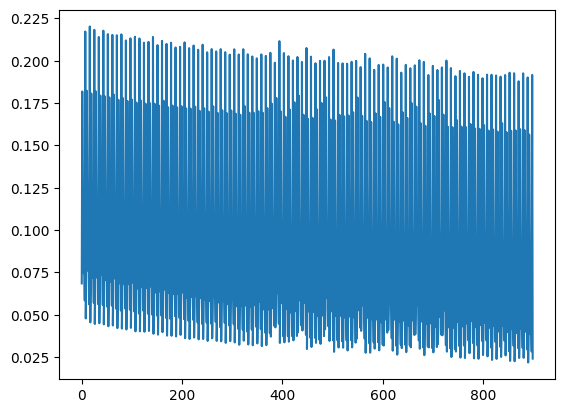

In [70]:
plt.plot(train_test.loss_list[100:])

In [71]:
"""prediction"""
initial_piece_len = time_delay*(time_delay_dim-1) + 1
initial_piece = single_neuron.sol[:initial_piece_len, 0]
stimulus_list = stimulus.sol[initial_piece_len:, 0]
pred_run = generate_prediction(pred_model, time_delay, time_delay_dim, stimulus_list, initial_piece)
pred_run.run(params, n_steps=1000)

100%|██████████| 1000/1000 [00:43<00:00, 22.82it/s]


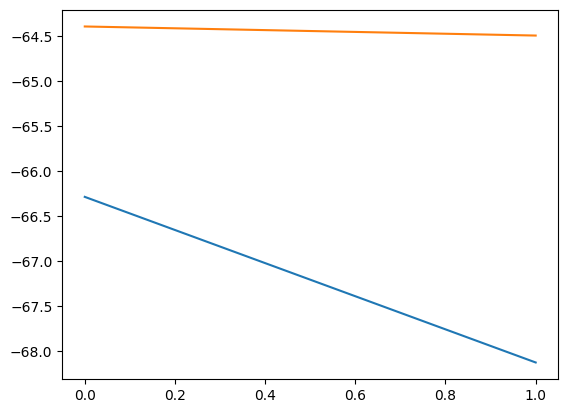

In [77]:
start = initial_piece_len - 0
end = initial_piece_len + 2
plt.plot(pred_run.prediction_list[start:end])
plt.plot(single_neuron.sol[start:end, 0])

In [75]:
print(initial_piece[[0, 10, 20, 30, 40]])
single_neuron.sol[:initial_piece_len, 0][[0, 10, 20, 30, 40]]

[  0.         -14.76562587 -40.53436352 -54.12519624 -64.2201944 ]


array([  0.        , -14.76562587, -40.53436352, -54.12519624,
       -64.2201944 ])

In [76]:
pred_model.apply(params, single_neuron.sol[:initial_piece_len, 0][[0, 10, 20, 30, 40]], 15)

Array([-66.2872], dtype=float32)

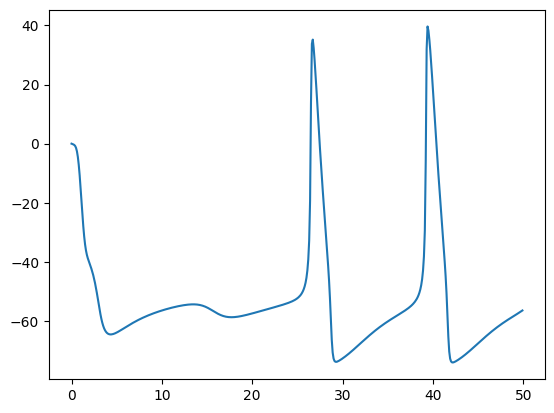

In [268]:
plt.plot(np.arange(*time_range)[:500], single_neuron.sol[:500, 0])